## Classification of Heart Disease Diagnosis

## Introduction

Processed Cleveland Data contains patient information including age and blood pressure. These attributes will be used to predict whether a patients has heart disease. In this proposal, we'll use machine learning to analyze the dataset and develop predictive models for heart disease diagnosis. The goal of this is to provide a tool to healthcare professionals to assist in early detection of heart disease. 

The question this model will try to answer is: can we accurately predict the presence of heart disease based on demographic and clinical attributes using the provided dataset. 

The data set containts information on 303 patients with 13 features about each one. The presence of heart disease is shown with integers ranging from 0 (no heart disease) to 4.

## Preliminary exploratory data analysis

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

variable_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
cleve_data <- read.table("data/processed.cleveland.data", header=TRUE, sep = ",", col.names = variable_names)
cleve_data

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


The above is our inital datatset read from the web. We are using the processed cleveland dataset as it has already been preprocessed into a tidy form.

We then select the columns we want:

In [30]:
cleve_data <- cleve_data |>
                select(age, sex, trestbps, chol, thalach, num) |>
                mutate(num = as_factor(num))
            

cleve_data

age,sex,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
67,1,160,286,108,2
67,1,120,229,129,1
37,1,130,250,187,0
⋮,⋮,⋮,⋮,⋮,⋮
57,1,130,131,115,3
57,0,130,236,174,1
38,1,138,175,173,0


We then split our data into 75% training and 25% testing. 

In [31]:
set.seed(1)

cleve_split <- initial_split(cleve_data, prop=0.75, strata=num)
cleve_train <- training(cleve_split)
cleve_test <- testing(cleve_split)

cleve_train
cleve_test

age,sex,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
37,1,130,250,187,0
56,1,120,236,178,0
44,1,120,263,173,0
⋮,⋮,⋮,⋮,⋮,⋮
55,0,128,205,130,3
59,1,164,176,90,3
57,1,130,131,115,3


age,sex,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
41,0,130,204,172,0
57,0,120,354,163,0
57,1,140,192,148,0
⋮,⋮,⋮,⋮,⋮,⋮
58,1,114,318,140,4
68,1,144,193,141,2
57,0,130,236,174,1


### Training Data Summary Table

Below is a table containing summary information regarding the number of observations in each class and the means of the predictor variables we selected from above. There are no missing values in any of these columns as stated in the dataset database.

In [32]:
cleve_train_summary <- cleve_train |>
  group_by(num) |>
  summarise(
    across(where(is.numeric), mean, na.rm = TRUE),  
    n = n()
  )

cleve_train_summary

num,age,sex,trestbps,chol,thalach,n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,52.00813,0.6097561,127.8130,240.2114,159.2358,123
1,55.68293,0.8292683,133.4878,248.7561,144.3171,41
2,57.56000,0.8400000,133.9200,265.0000,132.8000,25
3,55.15385,0.8846154,132.5769,241.7308,133.6538,26
4,58.50000,0.9000000,139.5000,239.5000,140.9000,10


### Training Data Visualization

We create a histogram using our training data to display the distribution of all our predictor variables. This lets us visualize our data and make sure our variables make sense. 

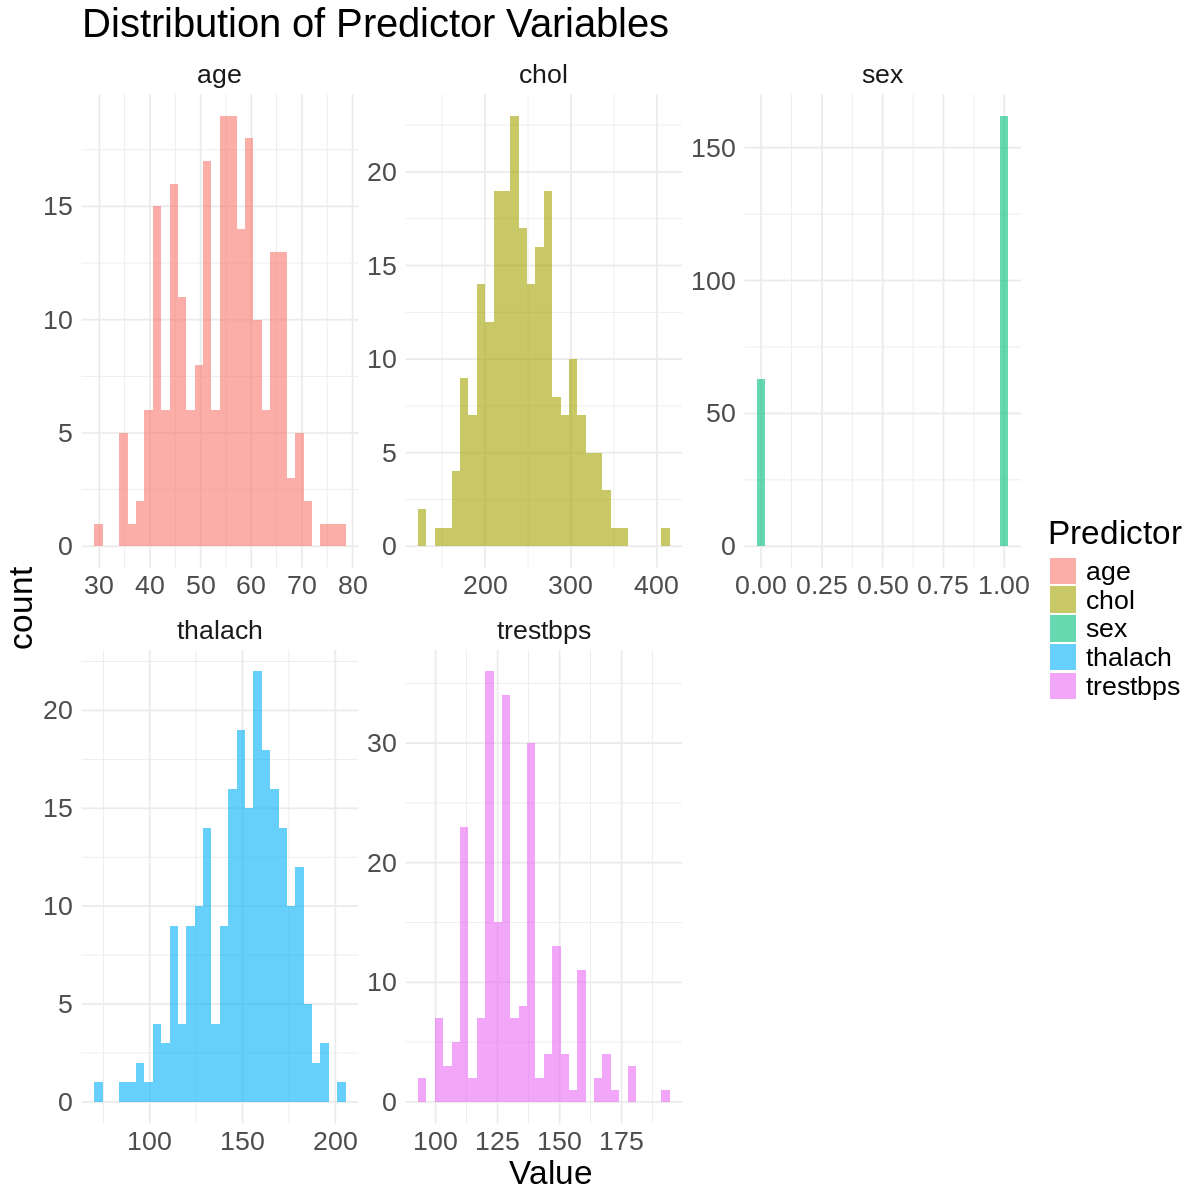

In [33]:
options(repr.plot.width = 10, repr.plot.height = 10)

predictor_variables <- c("age", "sex", "trestbps", "chol", "thalach")

data_long <- pivot_longer(cleve_train, cols = predictor_variables, names_to = "Predictor", values_to = "Value")

plot <- ggplot(data_long, aes(x = Value, fill = Predictor)) +
  geom_histogram(bins = 30, alpha = 0.6, position = "identity") +
  facet_wrap(~ Predictor, scales = "free") +
  theme_minimal() +
  labs(title = "Distribution of Predictor Variables") +
  theme(text = element_text(size = 20)) 

plot

## Methods


We will use KNN to classify whether a patient has heart disease. The variable we are looking to predict is represented by the num column. 

First, we will put the variables we wish to use as predictors into a **recipe** and both **scale** and **center** them. 

Next, we will create a **model specification** that will tune for the best k value. 

After, we will perform a **5-fold cross-validation** on the training set and create a **workflow** that includes our recipe and model specification. We will try all integer k-values from 2 - 10 and plot the results to determine the most accurate k-value.

Finally, we will create our model by adding both a new **model specification** that will use straight line distance and found k and the recipe we made before to a new **workflow**. We will use this model to **predict** the values in our testing set. We will also check our model's **accuracy**, **precision**, and **recall** using **metrics** and the **confusion matrix**.

We will visualize these results by using scatterplots to compare two variables against the class we are predicting (represented by colour) and then plot the test observations to see whether our model has correctly predicted the class of heart disease.

In [34]:
#Recipe
cleve_recipe <- recipe(num ~ ., data=cleve_train) |>
                step_scale(predictor_variables) |>
                step_center(predictor_variables) |>
                prep()

In [35]:
#Model Specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [36]:
#cross val
folds <- vfold_cv(cleve_train, v = 5, strata = num)

→ A | warning: No observations were detected in `truth` for level(s): '4'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x2





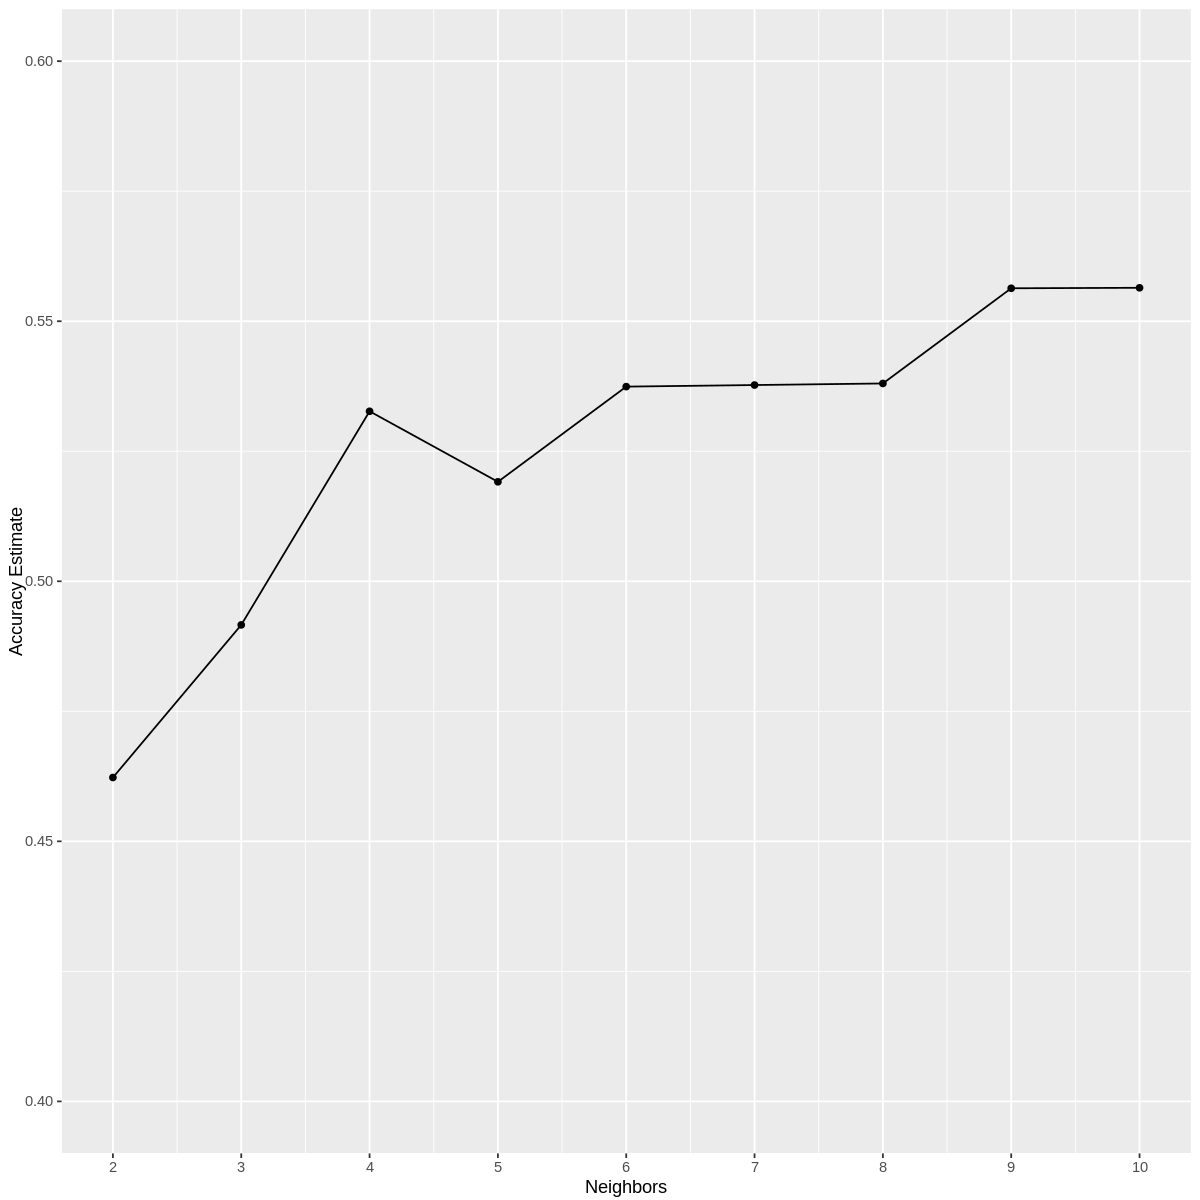

In [43]:
#workflow

k_vals <- tibble(neighbors = seq(from = 2, to = 10))

results <- workflow() |>
        add_recipe(cleve_recipe) |>
        add_model(knn_spec) |>
        tune_grid(resamples = folds, grid = k_vals)

metrics <- collect_metrics(results)

accuracies <- metrics |> 
       filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 0.6)) # adjusting the y-axis
cross_val_plot

In [48]:
#new model 
new_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) |>
                set_engine("kknn") |>
                set_mode("classification")

new_fit <- workflow() |>
             add_recipe(cleve_recipe) |>
             add_model(new_spec) |>
             fit(data = cleve_train)
new_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(4,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.44
Best kernel: rectangular
Best k: 4

In [54]:
#Testing

cleve_predictions <- predict(new_fit, cleve_test) |>
            bind_cols(cleve_test |> select(num))
cleve_predictions

cleve_metrics <- cleve_predictions |>
                  metrics(truth = num, estimate = .pred_class)
cleve_metrics

cleve_conf_mat <- cleve_predictions |>
                  conf_mat(truth = num, estimate = .pred_class)
cleve_conf_mat

.pred_class,num
<fct>,<fct>
0,0
0,0
1,0
⋮,⋮
0,4
1,2
0,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4935065
kap,multiclass,0.1437126


          Truth
Prediction  0  1  2  3  4
         0 35  6  8  3  2
         1  2  2  3  4  0
         2  2  2  0  2  0
         3  1  3  0  0  0
         4  0  1  0  0  1

age,sex,trestbps,chol,thalach,num,pred_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
41,0,130,204,172,0,0
57,0,120,354,163,0,0
57,1,140,192,148,0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
58,1,114,318,140,4,0
68,1,144,193,141,2,1
57,0,130,236,174,1,0


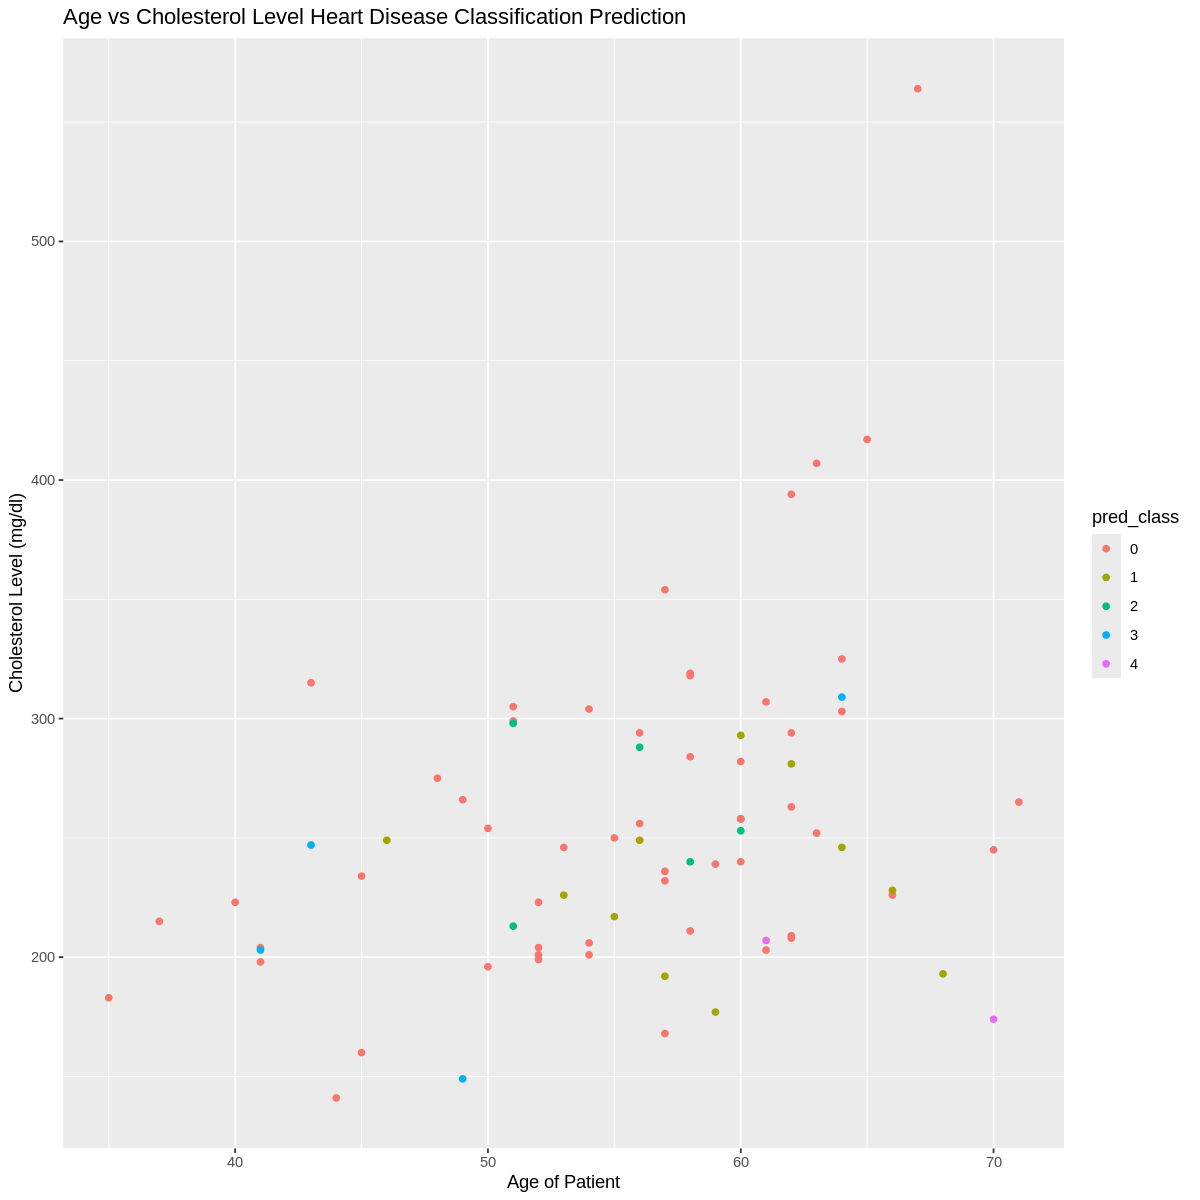

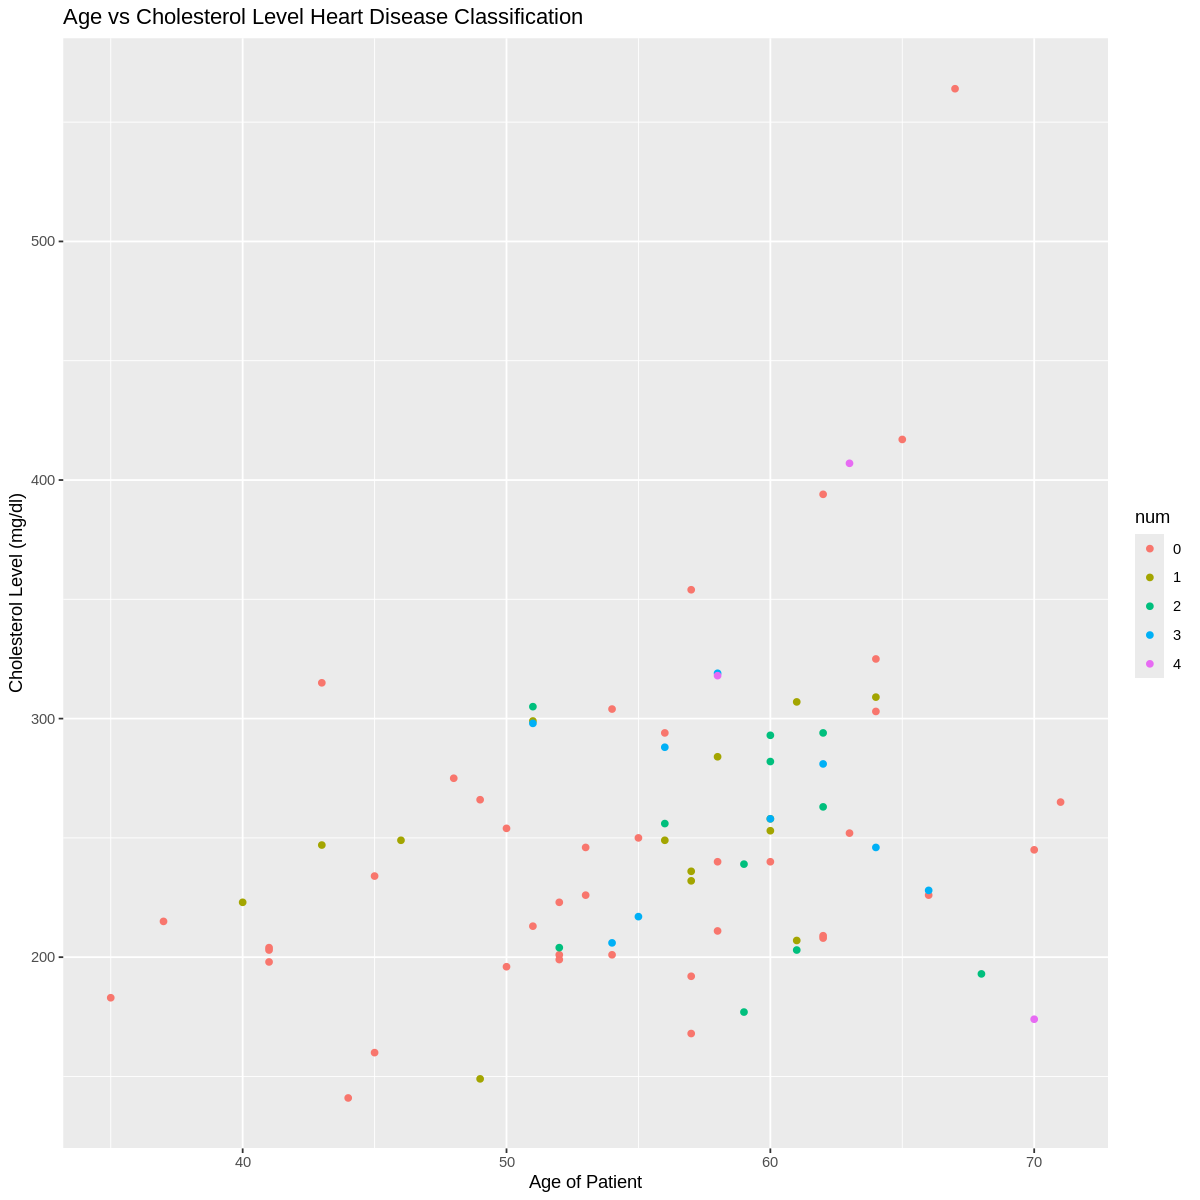

In [75]:
#plot
cleve_test["pred_class"] = cleve_predictions[".pred_class"]
cleve_test

pred_plot <- cleve_test |>
                    ggplot(aes(x = age, y = chol)) +
                    geom_point(aes(color = pred_class)) +
                    labs(x = "Age of Patient", y = "Cholesterol Level (mg/dl)", color = "pred_class") +
                    ggtitle("Age vs Cholesterol Level Heart Disease Classification Prediction")
pred_plot

num_plot <- cleve_test |>
                    ggplot(aes(x = age, y = chol)) +
                    geom_point(aes(color = num)) +
                    labs(x = "Age of Patient", y = "Cholesterol Level (mg/dl)", color = "num") +
                    ggtitle("Age vs Cholesterol Level Heart Disease Classification")
num_plot

## Expected outcomes and significance

Through this study, we hope to discover significant predictors of heart disease.

This would result in being able to identify if someone would require additional investigation in regards to heart disease simply by considering the predictors found. This would further help with public health policy development and risk assessment. Further questions could include expanding the list of predictors. 